# **Problem Definition**

With the widespread use of social media, harmful content such as hate speech and offensive language has become increasingly common. These types of posts can cause serious social and psychological harm, which makes their detection an important issue. Relying on manual moderation is not practical due to the huge amount of text generated every day, so automated solutions are necessary.

In this project, we address the problem of **hate speech detection using deep learning**, treating it as a **multi-class text classification task**. Each tweet in the dataset is classified into one of the following three categories:

* **Hate Speech (Class 0):** Tweets that directly target individuals or groups with hateful or harmful intent.
* **Offensive Language (Class 1):** Tweets that contain offensive or abusive language but are not explicitly hateful.
* **Neither (Class 2):** Tweets that are neutral and do not contain offensive or hateful content.

The dataset used in this project contains 24,783 labeled tweets. One of the main challenges of this dataset is the class imbalance, where the majority of tweets belong to the offensive language class, while hate speech and neutral tweets are much fewer. This imbalance can negatively affect model performance, especially when trying to correctly identify minority classes.

To overcome these challenges, several NLP preprocessing steps are applied to clean and normalize the text data. In addition, data augmentation techniques are used to reduce the effect of class imbalance. An LSTM-based deep learning model is then trained to learn sequential patterns in the text and perform accurate classification.

The model performance is evaluated on both training and testing sets, and different hyperparameters are explored to achieve the best possible results.

# Import Libraries

In [ ]:
import re
import nltk
import emoji
import random
import numpy as np
import pandas as pd
from collections import Counter
import nlpaug.augmenter.word as naw

import plotly.graph_objects as go

import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.utils import resample, shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [2]:
aug = naw.SynonymAug(aug_src='wordnet')

# Define Classes and Functions

## Text Cleaner Class

The function preprocesses each tweet by converting it to lowercase and removing URLs, emails, phone numbers, punctuation, numbers, and extra whitespace. Retweet markers, mentions, and hashtag symbols are also removed. Emojis are separated so they can be treated as individual tokens. This ensures that the text is clean, consistent, and ready for tokenization and modeling.


In [ ]:
class TextCleaner:
    def __init__(self):
        pass

    def _separate_emojis(self, text: str) -> str:
        return emoji.replace_emoji(
            text,
            replace=lambda em, _: f" {em} "
        )

    def clean(self, text: str) -> str:
        text = str(text).lower()
        text = self._separate_emojis(text)

        URL_REGEX = r"http\S+|www\S+|https\S+"
        EMAIL_REGEX = r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b"
        PHONE_REGEX = r"\+?\d[\d\s\-\(\)]{7,}\d"

        text = re.sub(r"[!\"#$%&'()*+,\-./:;<=>?@\[\]\\^_`{|}~]", "", text) # Remove punctuation
        text = re.sub(URL_REGEX, '', text) # Remove URLs
        text = re.sub(EMAIL_REGEX, '', text) # Remove emails
        text = re.sub(PHONE_REGEX, '', text) # Remove phone numbers
        text = re.sub(r'\brt\b', '', text) # Remove retweet indicators
        text = re.sub(r'@\w+', '', text) # Remove mentions
        text = re.sub(r'#', '', text) # Remove hashtag symbol
        text = re.sub(r'\d+', '', text) # Remove numbers
        text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace

        return text

    def transform(self, texts):
        return [self.clean(t) for t in texts]


## Text Preprocessor Class

In [4]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()

    def _get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def tokenize(self, text: str):
        tokens = text.split()
        tokens = [t for t in tokens if t not in self.stop_words]

        tags = nltk.pos_tag(tokens)
        tokens = [
            self.lemmatizer.lemmatize(word, self._get_wordnet_pos(tag))
            for word, tag in tags
        ]

        return tokens

    def transform(self, cleaned_texts):
        return [self.tokenize(text) for text in cleaned_texts]


## Sequence Length Filter Class

In [5]:
class SequenceLengthFilter:
    def __init__(self, factor=1.5):
        self.factor = factor
        self.upper_bound = None

    def fit(self, tokenized_texts):
        lengths = np.array([len(seq) for seq in tokenized_texts])

        q1 = np.percentile(lengths, 25)
        q3 = np.percentile(lengths, 75)
        iqr = q3 - q1
        self.upper_bound = int(np.floor(q3 + self.factor * iqr))
    
        return self

    def transform(self, tokenized_texts, labels):
        assert self.upper_bound is not None, "Call fit() first"

        mask = np.array([len(seq) <= self.upper_bound for seq in tokenized_texts])

        X_filtered = pd.Series(tokenized_texts)[mask].reset_index(drop=True)
        y_filtered = labels[mask].reset_index(drop=True)
        
        print(f"Original samples: {len(tokenized_texts)}")
        print(f"Remaining samples: {len(X_filtered)}")
        print(f"Dropped samples: {len(tokenized_texts) - len(X_filtered)}")

        return X_filtered.tolist(), y_filtered

    def get_max_len(self, tokenized_texts):
        return max(len(seq) for seq in tokenized_texts)


## Vocabulary Builder Class

In [6]:
class VocabularyBuilder:
    def __init__(self, min_freq=1):
        self.min_freq = min_freq
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.fitted = False

    def fit(self, tokenized_texts):
        counter = Counter()

        for sentence in tokenized_texts:
            counter.update(sentence)

        idx = 2
        for word, freq in counter.most_common():
            if freq >= self.min_freq:
                self.word2idx[word] = idx
                idx += 1

        self.fitted = True

    def encode_word(self, word):
        return self.word2idx.get(word, self.word2idx["<UNK>"])

    def vocab_size(self):
        return len(self.word2idx)


## Sequence Encoder Class

In [7]:
class SequenceEncoder:
    def __init__(self, vocab: VocabularyBuilder, max_len: int):
        assert vocab.fitted, "Vocabulary must be fitted first"
        self.vocab = vocab
        self.max_len = max_len

    def encode(self, tokenized_text):
        return [self.vocab.encode_word(word) for word in tokenized_text]

    def pad(self, sequence):
        if len(sequence) > self.max_len:
            return sequence[:self.max_len]
        return sequence + [0] * (self.max_len - len(sequence))

    def transform(self, tokenized_texts):
        encoded = [self.encode(text) for text in tokenized_texts]
        padded = [self.pad(seq) for seq in encoded]
        return np.array(padded, dtype=np.int32)



## Pre-training Pipeline Function

In [8]:
def pretraining_pipeline(X_train, y_train, X_test, min_freq=1, iqr_factor=1.5):

    # 1. Preprocessing
    preprocessor = TextPreprocessor()
    X_train_tokens = preprocessor.transform(X_train)
    X_test_tokens  = preprocessor.transform(X_test)

    # 2. Drop length outliers (TRAIN ONLY)
    length_filter = SequenceLengthFilter(factor=iqr_factor)
    length_filter.fit(X_train_tokens)

    X_train_tokens, y_train_filtered = length_filter.transform(X_train_tokens, y_train)

    # 3. Define MAX_LEN
    MAX_LEN = length_filter.get_max_len(X_train_tokens)
    print("Chosen MAX_LEN:", MAX_LEN)

    # 4. Vocabulary (TRAIN ONLY)
    vocab = VocabularyBuilder(min_freq=min_freq)
    vocab.fit(X_train_tokens)
    print("Vocab size:", vocab.vocab_size())
    
    # 5. Encode + pad
    encoder = SequenceEncoder(vocab, MAX_LEN)

    X_train_tensor = encoder.transform(X_train_tokens)
    X_test_tensor  = encoder.transform(X_test_tokens)
    
    X_train = np.array(X_train_tensor)
    X_test  = np.array(X_test_tensor)


    return X_train, y_train_filtered, X_test, vocab.vocab_size()


# Load Dataset

In [9]:
df = pd.read_csv("Datasets/hate_speech.csv")
df.head(10)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,1,""" &amp; you might not get ya bitch back &amp; ..."
9,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


# Exploratory Data Analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [11]:
counts = df['class'].value_counts().sort_index()
counts

class
0     1430
1    19190
2     4163
Name: count, dtype: int64

In [12]:
df['class'].value_counts(normalize=True).sort_index() * 100

class
0     5.770084
1    77.432111
2    16.797805
Name: proportion, dtype: float64

In [13]:
counts.reset_index()

,class,count
0,0,1430
1,1,19190
2,2,4163


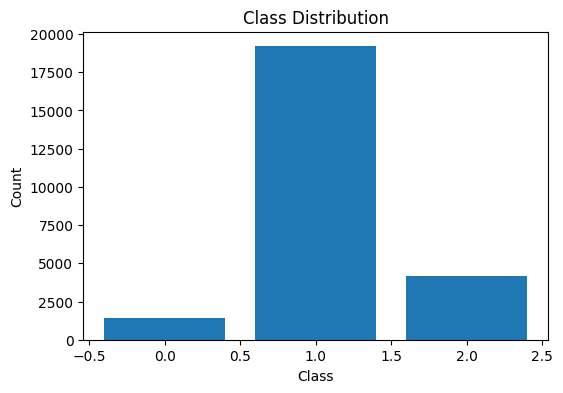

In [14]:
# Prepare data
df_counts = counts.reset_index()
df_counts.columns = ['class', 'count']

# Plot
plt.figure(figsize=(6, 4))
plt.bar(df_counts['class'], df_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.show()

# Clean Text

#### before cleaning

In [15]:
df['tweet']

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [16]:
cleaner = TextCleaner()
df['tweet'] = cleaner.transform(df['tweet'])
df.to_csv('Datasets/cleaned_hate_speech.csv', index=False)

#### after cleaning

In [17]:
df['tweet']

0        mayasolovely as a woman you shouldnt complain ...
1        mleew boy dats coldtyga dwn bad for cuffin dat...
2        urkindofbrand dawg sbabylife you ever fuck a b...
3              cganderson vivabased she look like a tranny
4        shenikaroberts the shit you hear about me migh...
                               ...                        
24778    yous a muthafin lie lifeasking pearls coreyema...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled | ntac eileen dahlia beautiful color...
Name: tweet, Length: 24783, dtype: object

# Dataset Preparation Approaches

## No Augmentation

### Split Train-Test

In [18]:
df = pd.read_csv("Datasets/cleaned_hate_speech.csv")

In [19]:
X = df['tweet']
y = df['class']

The stratified split successfully maintains the same relative proportions of each class in both sets, ensuring that the model is trained and evaluated fairly across all classes.

In [20]:
# Stratified split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [21]:
# n rows for each
X_train.shape[0], X_test.shape[0]

(19826, 4957)

### EDA

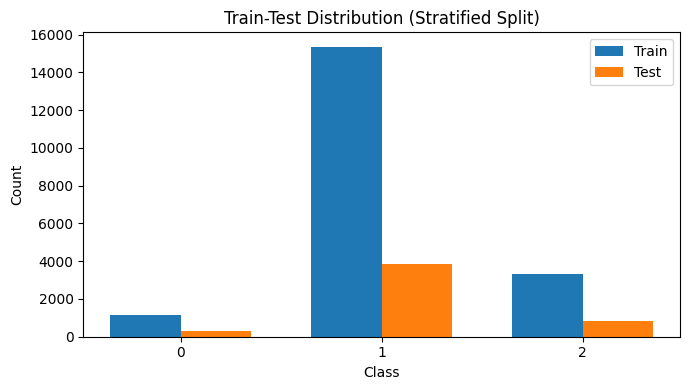

In [22]:
# Classes
classes = [0, 1, 2]

# Counts
train_counts = y_train.value_counts().sort_index()
test_counts  = y_test.value_counts().sort_index()

# Bar positions
x = np.arange(len(classes))
width = 0.35

# Plot
plt.figure(figsize=(7, 4))
plt.bar(x - width/2, train_counts, width, label='Train')
plt.bar(x + width/2, test_counts,  width, label='Test')

# Labels & title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train-Test Distribution (Stratified Split)')
plt.xticks(x, classes)
plt.legend()

plt.tight_layout()
plt.show()


The severe class imbalance highlights the need for data augmentation or other techniques to prevent the model from being biased toward the majority class.

Minority classes (0 and 2) require augmentation/class weights to improve detection performance.

In [23]:
preprocessor = TextPreprocessor()
X_train_tokens = preprocessor.transform(X_train)

In [24]:
lengths = [len(seq) for seq in X_train]
MAX_LEN = max(lengths)
MAX_LEN

207

In [25]:
preprocessed_lengths = [len(seq) for seq in X_train_tokens]
MAX_LEN = max(preprocessed_lengths)
MAX_LEN

84

### Box Plot

In [26]:
data = np.array(lengths)
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)

IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
int(np.floor(upper_bound)), max(lengths)

(187, 207)

before preprocessing

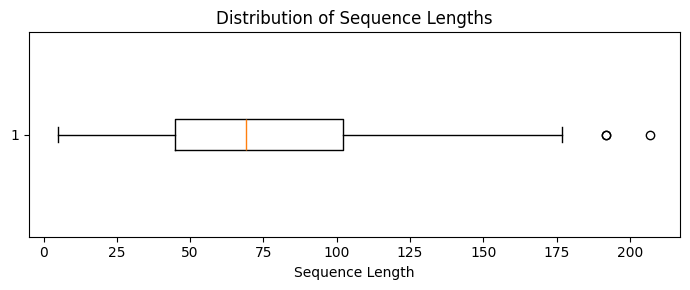

In [27]:
plt.figure(figsize=(7, 3))
plt.boxplot(np.array(lengths), vert=False)

plt.xlabel("Sequence Length")
plt.title("Distribution of Sequence Lengths")

plt.tight_layout()
plt.show()


after preprocessing

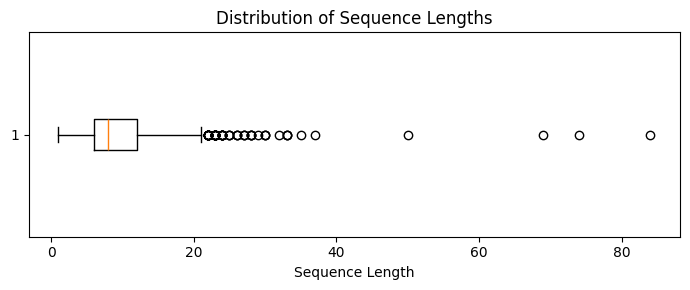

In [28]:
plt.figure(figsize=(7, 3))
plt.boxplot(np.array(preprocessed_lengths), vert=False)

plt.xlabel("Sequence Length")
plt.title("Distribution of Sequence Lengths")

plt.tight_layout()
plt.show()


### Dist Plot

#### Before Preprocessing

In [29]:
length_counts = Counter(lengths)
x = list(length_counts.keys())
y = list(length_counts.values())

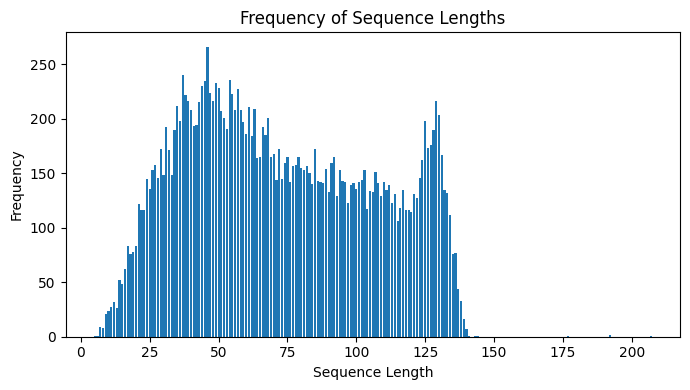

In [30]:
plt.figure(figsize=(7, 4))
plt.bar(x, y)

plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Frequency of Sequence Lengths")

plt.tight_layout()
plt.show()


#### After Preprocessing

In [31]:
preprocessed_length_counts = Counter(preprocessed_lengths)
x = list(preprocessed_length_counts.keys())
y = list(preprocessed_length_counts.values())

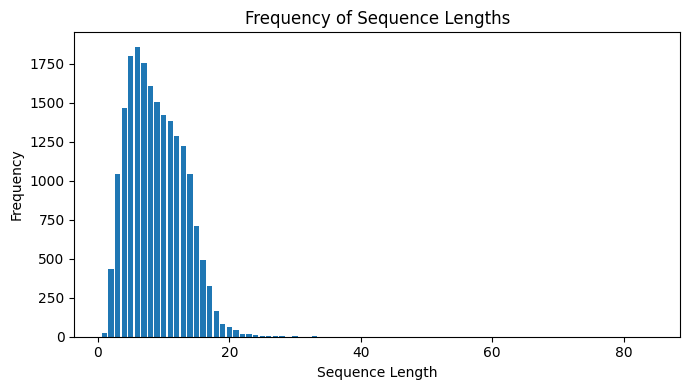

In [32]:
plt.figure(figsize=(7, 4))
plt.bar(x, y)

plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Frequency of Sequence Lengths")

plt.tight_layout()
plt.show()


In [33]:
df_len = (
    pd.DataFrame(preprocessed_length_counts.items(), columns=["length", "count"])
    .sort_values("length", ascending=False)   # MAX_LEN → 0
    .reset_index(drop=True)
)

df_len["cumulative_count"] = df_len["count"].cumsum()

total_sequences = df_len["count"].sum()

df_len["cumulative_percentage"] = (df_len["cumulative_count"] / total_sequences * 100)

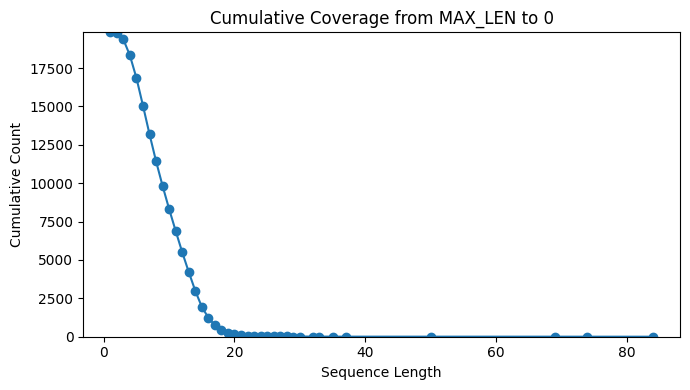

In [34]:
plt.figure(figsize=(7, 4))

plt.plot(df_len["length"], df_len["cumulative_count"], marker='o')

plt.xlabel("Sequence Length")
plt.ylabel("Cumulative Count")
plt.title("Cumulative Coverage from MAX_LEN to 0")

# Match Plotly behavior
plt.ylim(0, len(lengths))

plt.tight_layout()
plt.show()


Since a very small percentage of the data's sequence length is above 21, we will make that the sequence length instead of making the maximum (84) the padding length and waste a lot of ..
For those above of 21 we will drop them instead of splitting since it is possible to lose the important part deciding the label in the split

In [35]:
words_counter = Counter()
for sentence in X_train_tokens:
    words_counter.update(sentence)

words_counter

Counter({'talk': 472,
         'angela': 2,
         'hoe': 3409,
         'lol': 844,
         'trick': 31,
         'niccas': 95,
         'leave': 151,
         'n': 223,
         'right': 319,
         '😂': 2531,
         'bitch': 9063,
         'get': 2440,
         'stuff': 19,
         'do': 108,
         '<url>': 2402,
         'artalegaspare': 1,
         'flameeee': 1,
         'vivaalakatyy': 6,
         'brotherbill': 3,
         'jhuff': 2,
         'good': 479,
         'choke': 23,
         'like': 2293,
         'say': 868,
         'word': 106,
         'pussy': 1795,
         'ion': 60,
         'forehead': 5,
         'hairline': 2,
         'lie': 112,
         'approve': 4,
         'shit': 1027,
         'mingtong': 1,
         'still': 377,
         'cunt': 226,
         'feel': 189,
         'bad': 483,
         'nicca': 136,
         'tho': 200,
         'ya': 387,
         'girl': 562,
         'log': 7,
         'nigger': 256,
         'polokingbc': 1,
      

In [36]:
top_10 = words_counter.most_common(10)
df_top10 = pd.DataFrame(top_10, columns=["token", "frequency"])
df_top10

,token,frequency
0,bitch,9063
1,hoe,3409
2,😂,2531
3,get,2440
4,<url>,2402
5,like,2293
6,pussy,1795
7,fuck,1702
8,im,1671
9,dont,1428


### Run pre-training pipeline

In [37]:
X_train, y_train, X_test, no_aug_vocab_len = pretraining_pipeline(X_train, y_train, X_test, min_freq=1, iqr_factor=1.5)

Original samples: 19826
Remaining samples: 19759
Dropped samples: 67
Chosen MAX_LEN: 21
Vocab size: 26570


### Save Train-Test

In [ ]:
# Save features
pd.DataFrame(X_train).to_csv('Datasets/no-aug/X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('Datasets/no-aug/X_test.csv', index=False)

# Save labels
pd.DataFrame(y_train).to_csv('Datasets/no-aug/Y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('Datasets/no-aug/Y_test.csv', index=False)

## Upsampling

In [39]:
df = pd.read_csv("Datasets/cleaned_hate_speech.csv")

### Split Train-Test

In [40]:
X = df['tweet']
y = df['class']

The stratified split successfully maintains the same relative proportions of each class in both sets, ensuring that the model is trained and evaluated fairly across all classes.

In [41]:
# Stratified split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [42]:
# n rows for each
X_train.shape[0], X_test.shape[0]

(19826, 4957)

### Class Distributions

In [43]:
# Count per class
class_counts = df['class'].value_counts()
print(class_counts)

# Convert to percentages
class_percent = df['class'].value_counts(normalize=True) * 100
print(class_percent)

class
1    19190
2     4163
0     1430
Name: count, dtype: int64
class
1    77.432111
2    16.797805
0     5.770084
Name: proportion, dtype: float64


### Augmentation Functions

#### Synonym Replacment

In [44]:
def synonym_replacement(sentence):
    words = sentence.split()
    new_words = []
    for w in words:
        synonyms = wordnet.synsets(w)
        if synonyms:
            syns = [lemma.name() for syn in synonyms for lemma in syn.lemmas() if lemma.name()!=w]
            new_words.append(random.choice(syns) if syns else w)
        else:
            new_words.append(w)
    return ' '.join(new_words)

#### Random Deletion

In [45]:
def random_deletion(sentence, p=0.1, important_words=[]):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = []
    for w in words:
        if w in important_words or random.random() > p:
            new_words.append(w)
    return ' '.join(new_words) if new_words else random.choice(words)

#### Random Swap

In [46]:
def random_swap(sentence):
    words = sentence.split()
    if len(words) < 2:
        return sentence
    idx1, idx2 = random.sample(range(len(words)), 2)
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

#### Random Augmentations

In [47]:
augmentations = [synonym_replacement, random_deletion, random_swap]

#### Apply Augmentations

In [48]:
aug_texts = []
aug_labels = []

for text, label in zip(X_train, y_train):
    # Always keep original
    aug_texts.append(text)
    aug_labels.append(label)

    # Apply augmentation only for minority classes (Hate=0, Neither=2)
    if label in [0,2]:
        # Randomly pick ONE augmentation per sentence
        aug_func = random.choice(augmentations)
        aug_text = aug_func(text)
        aug_texts.append(aug_text)
        aug_labels.append(label)

#### Append and Save New DataSet

In [49]:
X_train = pd.Series(aug_texts, name="tweet")
y_train = pd.Series(aug_labels, name="class")

In [ ]:
# Save features
pd.DataFrame(X_train).to_csv('Datasets/half-aug/X_train_augmented.csv', index=False)
pd.DataFrame(y_train).to_csv('Datasets/half-aug/Y_train_augmented.csv', index=False)

### Run pre-training pipeline

In [51]:
X_train, y_train, X_test, up_vocab_size = pretraining_pipeline(X_train, y_train, X_test, min_freq=1, iqr_factor=1.5)

Original samples: 24300
Remaining samples: 24190
Dropped samples: 110
Chosen MAX_LEN: 21
Vocab size: 29872


### Save Train-Test

In [ ]:
# Save features
pd.DataFrame(X_train).to_csv('Datasets/half-aug/X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('Datasets/half-aug/X_test.csv', index=False)

# Save labels
pd.DataFrame(y_train).to_csv('Datasets/half-aug/Y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('Datasets/half-aug/Y_test.csv', index=False)

## Down/Upsampling

### Downsampling

In [54]:
df = pd.read_csv("Datasets/cleaned_hate_speech.csv")

In [55]:
class_0 = df[df['class'] == 0]
class_1 = df[df['class'] == 1]
class_2 = df[df['class'] == 2]

In [56]:
# Downsample class 1 to 6000
class_1_downsampled = resample(class_1, n_samples=6000, random_state=42, replace=False)

In [57]:
df = pd.concat([class_0, class_1_downsampled, class_2])
df

,class,tweet
85,0,blackmantide whalelookyhere howdydowdy queer g...
89,0,cbbaby whitethunduh alsarabsss hes a beaner sm...
110,0,devilgrimz vigxrarts youre fucking gay blackli...
184,0,markroundtreejr lmfaoooo i hate black people <...
202,0,nochillpaz at least im not a nigger <url> lmfao
...,...,...
24736,2,yaya ho cute avi tho vivalaari i had no idea s...
24737,2,yea so about ntel s new friend all my friends ...
24767,2,you know what they say the early bird gets the...
24779,2,youve gone and broke the wrong heart baby and ...


In [58]:
# Shuffle the dataset
df = shuffle(df, random_state=42).reset_index(drop=True)
df

,class,tweet
0,1,thelovelycc whatever lol my tan line is retard...
1,1,kobe aint no hoe
2,2,kurtbusiek well pee is oft yellow
3,1,this nigga solving rubik cubes doing magic tri...
4,2,damn internal alarm clock woke up at am feelin...
...,...,...
11588,2,well jennas getting a yellow lab so i know whe...
11589,1,fuck these bitches kinghorsedick stop women ba...
11590,1,keyshbechillin have you bitches done your kega...
11591,0,jennifer lawrences nudes sooooo trash im still...


In [59]:
# new distribution
counts = df['class'].value_counts().sort_index()
counts

class
0    1430
1    6000
2    4163
Name: count, dtype: int64

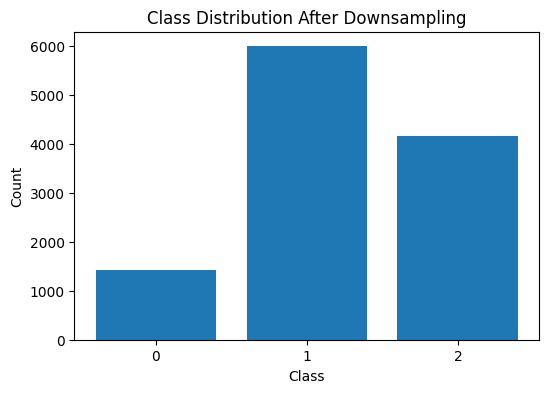

In [60]:
counts_df = counts.reset_index()
counts_df.columns = ['class', 'count']

plt.figure(figsize=(6, 4))
plt.bar(counts_df['class'], counts_df['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After Downsampling')
plt.xticks(counts_df['class'])
plt.show()

In [61]:
df.shape

(11593, 2)

#### Save Downsampled

In [ ]:
pd.DataFrame(df).to_csv('Datasets/full-aug/downsampled.csv', index=False)

### Train_Test split

In [63]:
X = df['tweet']
y = df['class']

In [64]:
# Stratified split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [65]:
# n rows for each
X_train.shape[0], X_test.shape[0]

(9274, 2319)

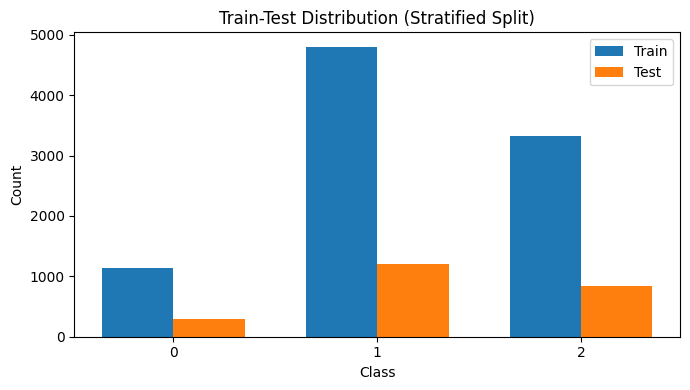

In [66]:
# Get counts
train_counts = y_train.value_counts().sort_index()
test_counts  = y_test.value_counts().sort_index()

classes = train_counts.index.tolist()   # [0, 1, 2]
x = np.arange(len(classes))             # [0, 1, 2]
width = 0.35                             # bar width

plt.figure(figsize=(7, 4))

# Plot bars
plt.bar(x - width/2, train_counts.values, width, label='Train')
plt.bar(x + width/2, test_counts.values,  width, label='Test')

# Labels & title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train-Test Distribution (Stratified Split)')
plt.xticks(x, classes)
plt.legend()

plt.tight_layout()
plt.show()

### Upsampling

In [67]:
X_train_class0 = X_train[y_train == 0]
X_train_class1 = X_train[y_train == 1]
X_train_class2 = X_train[y_train == 2]

In [68]:
y_train_class0 = y_train[y_train == 0]
y_train_class1 = y_train[y_train == 1]
y_train_class2 = y_train[y_train == 2]

In [69]:
y_train.value_counts().sort_index()

class
0    1144
1    4800
2    3330
Name: count, dtype: int64

In [70]:
# Augment Class 0 
augmented_texts = []
augmented_labels = []

# Create 1 augmented version for each sample = 2x total
for text in X_train_class0:
    # Generate 1 augmented version
    aug_text = aug.augment(text)
    # aug.augment() returns a list or string depending on version
    if isinstance(aug_text, list):
        augmented_texts.append(aug_text[0])
    else:
        augmented_texts.append(aug_text)
    augmented_labels.append(0)

In [71]:
# Convert to pandas Series
X_train_class0_augmented = pd.Series(augmented_texts, name='tweet')
y_train_class0_augmented = pd.Series(augmented_labels, name='class')

In [72]:
X_train_class0_combined = pd.concat([X_train_class0.reset_index(drop=True), 
                                      X_train_class0_augmented], ignore_index=True)
y_train_class0_combined = pd.concat([y_train_class0.reset_index(drop=True), 
                                      y_train_class0_augmented], ignore_index=True)

In [73]:
# Combine all classes back together
X_train_upsampled = pd.concat([X_train_class0_combined, 
                                X_train_class1.reset_index(drop=True), 
                                X_train_class2.reset_index(drop=True)], ignore_index=True)

y_train_upsampled = pd.concat([y_train_class0_combined, 
                                y_train_class1.reset_index(drop=True), 
                                y_train_class2.reset_index(drop=True)], ignore_index=True)

In [74]:
X_train_upsampled, y_train_upsampled = shuffle(X_train_upsampled, y_train_upsampled, random_state=42)


In [75]:
counts = y_train_upsampled.value_counts().sort_index()
counts

class
0    2288
1    4800
2    3330
Name: count, dtype: int64

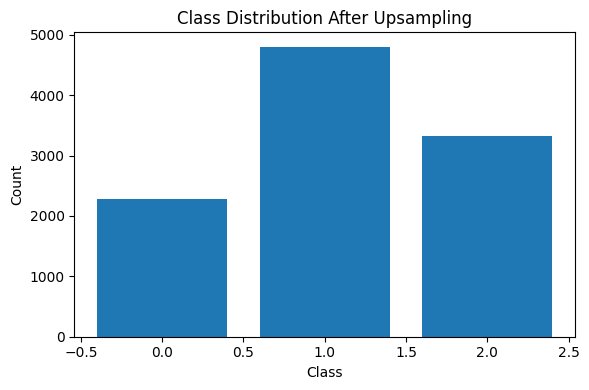

In [76]:
# counts is a Series: index=class, value=count
counts_df = counts.reset_index()
counts_df.columns = ['class', 'count']

plt.figure(figsize=(6, 4))
plt.bar(counts_df['class'], counts_df['count'])

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution After Upsampling')

plt.tight_layout()
plt.show()

In [77]:
X_train, y_train = X_train_upsampled, y_train_upsampled

#### save upsampled dataset

In [ ]:
# Save features
pd.DataFrame(X_train).to_csv('Datasets/full-aug/X_train_upsampled.csv', index=False)
pd.DataFrame(X_test).to_csv('Datasets/full-aug/X_test_upsampled.csv', index=False)

#### Run pre-training pipeline

In [79]:
X_train, y_train, X_test, down_up_vocab_count = pretraining_pipeline(X_train, y_train, X_test, min_freq=1, iqr_factor=1.5)

Original samples: 10418
Remaining samples: 10380
Dropped samples: 38
Chosen MAX_LEN: 21
Vocab size: 18129


#### Save Dataset

In [ ]:
# Save features
pd.DataFrame(X_train).to_csv('Datasets/full-aug/X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('Datasets/full-aug/X_test.csv', index=False)

# Save labels
pd.DataFrame(y_train).to_csv('Datasets/full-aug/Y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('Datasets/full-aug/Y_test.csv', index=False)

# LSTM Model

### Complete LSTM training pipeline with hyperparam grid and cross-validation.

#### Parameters
* **`X_train`**: Preprocessed tokens (list of token lists).
* **`y_train`**: Training labels.
* **`weighted_classes`**: Whether to use class weights for imbalanced data.
* **`cv_folds`**: Number of folds for cross-validation.
* **`final_epochs`**: Number of epochs for final training.
* **`batch_size`** (*int*): Batch size for training.
* **`model_save_path`**: Path to save the trained model.

#### Returns
**dict** containing:
* **`model`**: Trained Keras model.
* **`history`**: Training history object.
* **`best_params`**: Best hyperparameters from CV.
* **`cv_results`**: Cross-validation results.

In [103]:
class LSTMTrainer:
    def __init__(
        self,
        batch_size=64,
        cv_folds=3,
        final_epochs=30,
        weighted_classes=True,
        model_save_path="lstm_model.keras",
        base_params=None,
    ):
        self.batch_size = batch_size
        self.cv_folds = cv_folds
        self.final_epochs = final_epochs
        self.weighted_classes = weighted_classes
        self.model_save_path = model_save_path
        self.base_params = base_params 

        # Outputs
        self.best_params = None
        self.cv_results = None
        self.history = None
        self.model = None

    def _compute_class_weights(self, y):
        if not self.weighted_classes:
            return None
        weights = compute_class_weight(
            class_weight="balanced",
            classes=np.unique(y),
            y=y
        )
        return dict(enumerate(weights))

    def _build_model(self, embedding_dim, lstm_units, dropout_rate):
        model = Sequential([
            Embedding(MAX_VOCAB_SIZE, embedding_dim, mask_zero=True),
            LSTM(lstm_units),
            Dropout(dropout_rate),
            Dense(3, activation="softmax")
        ])
        model.compile(
            optimizer=Adam(),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        return model


    def _cross_validate(self, X, y, isWeighted = True):
        skf = StratifiedKFold(
            n_splits=self.cv_folds,
            shuffle=True,
            random_state=42
        )
    
        results = []
    
        param_grid = [
            (100, 64, 0.3),
            (100, 64, 0.4),
            (128, 64, 0.3),
            (128, 128, 0.4),
        ]
    
        print("\nCV Results per configuration:")
    
        for emb_dim, lstm_units, drop in param_grid:
            fold_acc = []
    
            for tr_idx, val_idx in skf.split(X, y):
                #tf.compat.v1.reset_default_graph()
    
                # Split per fold
                X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
                X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

                # Compute class weights ONLY on fold training data
                class_weight = self._compute_class_weights(y_tr) if isWeighted else None
                
                model = self._build_model(emb_dim, lstm_units, drop)
                model.fit(
                    X.iloc[tr_idx], y.iloc[tr_idx],
                    epochs=3,
                    batch_size=self.batch_size,
                    verbose=0,
                    class_weight=class_weight,
                    shuffle=True
                )
    
                _, acc = model.evaluate(
                    X.iloc[val_idx], y.iloc[val_idx], verbose=0
                )
                fold_acc.append(acc)
    
            mean_acc = np.mean(fold_acc)
    
            print(
                f"Embedding={emb_dim}, LSTM={lstm_units}, Dropout={drop} "
                f"→ CV Accuracy: {mean_acc:.4f}"
            )
    
            results.append({
                "embedding_dim": emb_dim,
                "lstm_units": lstm_units,
                "dropout": drop,
                "cv_accuracy": mean_acc
            })
    
        return results


    def plot_cv_results(self):
        df = pd.DataFrame(self.cv_results)

        # Create configuration labels
        df["config"] = (
            "emb=" + df["embedding_dim"].astype(str) +
            ", lstm=" + df["lstm_units"].astype(str) +
            ", drop=" + df["dropout"].astype(str)
        )

        plt.figure(figsize=(10, 5))
        bars = plt.bar(df["config"], df["cv_accuracy"])

        # Add text on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.4f}",
                ha="center",
                va="bottom",
                fontsize=9
            )

        plt.ylim(0, 1)
        plt.ylabel("Cross-Validation Accuracy")
        plt.xlabel("Hyperparameter Configuration")
        plt.title("Cross-Validation Accuracy per Hyperparameter Configuration")
        plt.xticks(rotation=45, ha="right")

        plt.tight_layout()
        plt.show()

    

    def _train_final_model(self, X, y, class_weight):
        #tf.compat.v1.reset_default_graph()

        self.model = self._build_model(*self.best_params)

        early_stopping = EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        )

        self.history = self.model.fit(
            X, y,
            validation_split=0.1,
            epochs=self.final_epochs,
            batch_size=self.batch_size,
            callbacks=[early_stopping],
            class_weight=class_weight,
            shuffle=True,
            verbose=1
        )

        self.model.save(self.model_save_path)


    def plot_training_history(self):
        history_df = pd.DataFrame(self.history.history)
    
        fig = go.Figure()
    
        fig.add_trace(go.Scatter(
            y=history_df["accuracy"],
            mode="lines",
            name="Train Accuracy"
        ))
    
        fig.add_trace(go.Scatter(
            y=history_df["val_accuracy"],
            mode="lines",
            name="Validation Accuracy"
        ))
    
        fig.update_layout(
            title="Training vs Validation Accuracy",
            xaxis_title="Epoch",
            yaxis_title="Accuracy"
        )
    
        fig.show()
    

    def run_pipeline(self, X, y, cv=False, isWeighted = True):
        
        class_weight = self._compute_class_weights(y) if isWeighted else None

        if cv == True:        
            # Run cross-validation and store results
            self.cv_results = self._cross_validate(X, y, isWeighted)
            
            # Select best hyperparameters
            best_result = max(self.cv_results, key=lambda x: x["cv_accuracy"])
            self.best_params = (
                best_result["embedding_dim"],
                best_result["lstm_units"],
                best_result["dropout"]
            )
            best_acc = best_result["cv_accuracy"]
            
            print(f"\n✓ Best Params: {self.best_params}")
            print(f"✓ Best CV Accuracy: {best_acc:.4f}")
            
            # Plot CV results
            self.plot_cv_results()
            print(f"\n✓ Using hyperparameters: {self.best_params}")

        else:
            # Use base_params if provided, otherwise fallback default
            if self.base_params is not None:
                self.best_params = self.base_params
            else:
                self.best_params = (128, 64, 0.3) 
            
    
        print("\nTraining final model...")
        self._train_final_model(X, y, class_weight)
    
        self.plot_training_history()
        
        return {
            "model": self.model,
            "history": self.history,
            "best_params": self.best_params,
            "cv_results": self.cv_results
        }

# Test & Evaluation

### Complete LSTM Evaluation Pipeline

**Parameters**

* **`model_path`**: Path to the saved model (`.h5` file).
* **`X_test`**: Test data.
* **`y_test`**: Test labels.

**Returns**

* **`dict`**: A dictionary containing:
    * `accuracy`: Test accuracy.
    * `classification_report`: Detailed classification metrics.
    * `confusion_matrix`: Confusion matrix.
    * `predictions`: Model predictions.

In [89]:
def evaluate_lstm_pipeline(model_path, X_test, y_test):
    model = load_model(model_path)
    print(f"✓ Model loaded from: {model_path}")
    
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Classification report
    labels = ["Hate", "Offensive", "Neutral"]
    print("\nClassification Report:")
    report = classification_report(
        y_test,
        y_pred,
        target_names=labels,
        digits=4
    )
    print(report)
    
    # Macro and Weighted metrics
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(
        cm,
        index=[f"True {l}" for l in labels],
        columns=[f"Pred {l}" for l in labels]
    )
    
    plt.figure(figsize=(6, 5))
    plt.imshow(df_cm, cmap="Blues")
    plt.colorbar(label="Count")

    # Axis labels
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # Tick labels
    plt.xticks(ticks=np.arange(len(labels)), labels=labels)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)

    # Annotate cells with counts
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(
                j, i,
                df_cm.iloc[i, j],
                ha="center",
                va="center",
                color="black"
            )

    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': test_acc,
        'loss': test_loss,
        'classification_report': report,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_probs,
        'metrics': {
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted
        }
    }

# Running

## No aug (without weight class)

In [ ]:
X_train = pd.read_csv('Datasets/no-aug/X_train.csv').squeeze()
X_test = pd.read_csv('Datasets/no-aug/X_test.csv').squeeze()
y_train = pd.read_csv('Datasets/no-aug/Y_train.csv').squeeze()
y_test = pd.read_csv('Datasets/no-aug/Y_test.csv').squeeze()

In [91]:
MAX_VOCAB_SIZE = no_aug_vocab_len


CV Results per configuration:
Embedding=100, LSTM=64, Dropout=0.3 → CV Accuracy: 0.8825
Embedding=100, LSTM=64, Dropout=0.4 → CV Accuracy: 0.8799
Embedding=128, LSTM=64, Dropout=0.3 → CV Accuracy: 0.8844
Embedding=128, LSTM=128, Dropout=0.4 → CV Accuracy: 0.8855

✓ Best Params: (128, 128, 0.4)
✓ Best CV Accuracy: 0.8855


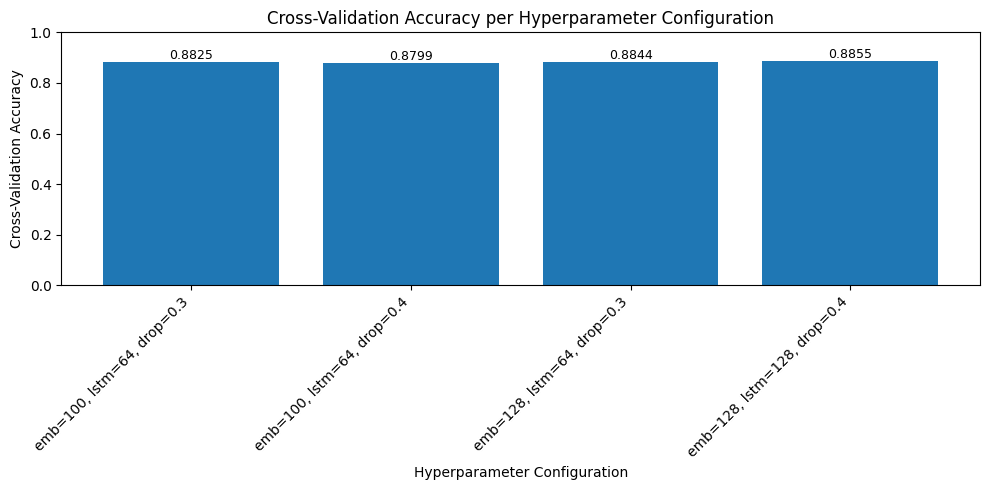


Training final model...
Epoch 1/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 60s 184ms/step - accuracy: 0.8661 - loss: 0.3961 - val_accuracy: 0.9064 - val_loss: 0.2628
Epoch 2/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.9383 - loss: 0.1933 - val_accuracy: 0.9023 - val_loss: 0.2892
Epoch 3/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - accuracy: 0.9687 - loss: 0.0983 - val_accuracy: 0.8932 - val_loss: 0.3462
Epoch 4/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 45s 163ms/step - accuracy: 0.9835 - loss: 0.0526 - val_accuracy: 0.8937 - val_loss: 0.4069
Epoch 5/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 44s 159ms/step - accuracy: 0.9888 - loss: 0.0387 - val_accuracy: 0.8735 - val_loss: 0.5054
Epoch 6/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 46s 164ms/step - accuracy: 0.9916 - loss: 0.0270 - val_accuracy: 0.8871 - val_loss: 0.5016


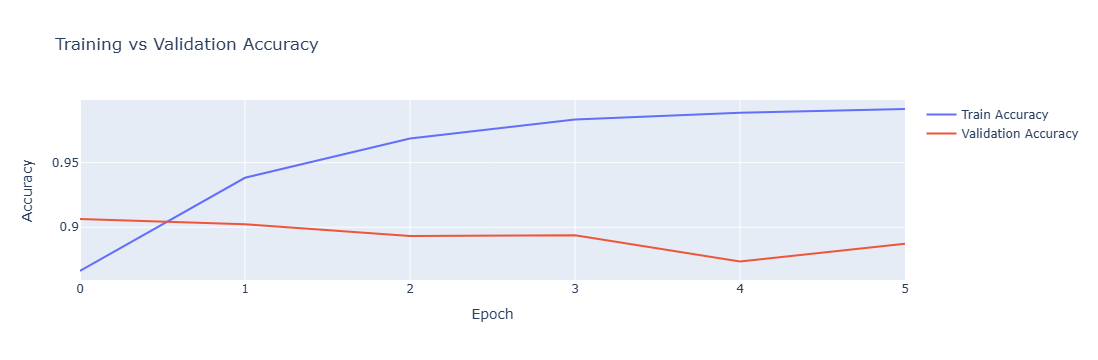

In [92]:
trainer = LSTMTrainer()
results = trainer.run_pipeline(X_train, y_train, False, cv=True)

✓ Model loaded from: lstm_model.h5
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step

Test Accuracy: 93.49%
Test Loss: 0.2071

Classification Report:
              precision    recall  f1-score   support

        Hate     0.7655    0.3144    0.4457      1142
   Offensive     0.9496    0.9761    0.9626     15295
     Neutral     0.8927    0.9588    0.9245      3322

    accuracy                         0.9349     19759
   macro avg     0.8692    0.7497    0.7776     19759
weighted avg     0.9294    0.9349    0.9263     19759



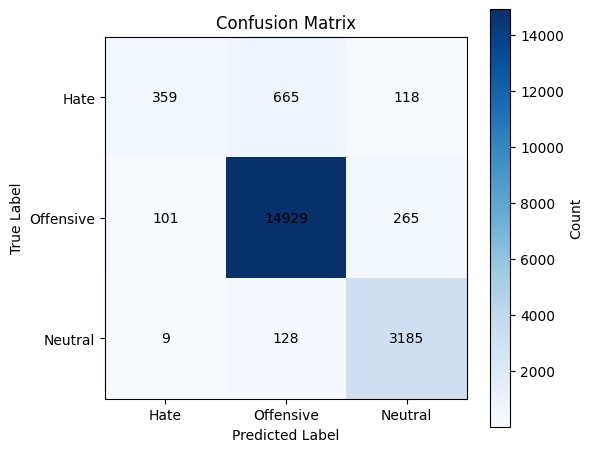

In [93]:
eval_results = evaluate_lstm_pipeline(
    model_path='lstm_model.h5',
    X_test=X_train,
    y_test=y_train
)

The model learns the dominant Offensive class very well.

It achieves a very low recall for hate since it is a rare class in the data.

✓ Model loaded from: lstm_model.h5
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step

Test Accuracy: 89.73%
Test Loss: 0.2857

Classification Report:
              precision    recall  f1-score   support

        Hate     0.6064    0.1993    0.3000       286
   Offensive     0.9301    0.9500    0.9399      3838
     Neutral     0.7900    0.8944    0.8390       833

    accuracy                         0.8973      4957
   macro avg     0.7755    0.6812    0.6930      4957
weighted avg     0.8879    0.8973    0.8860      4957



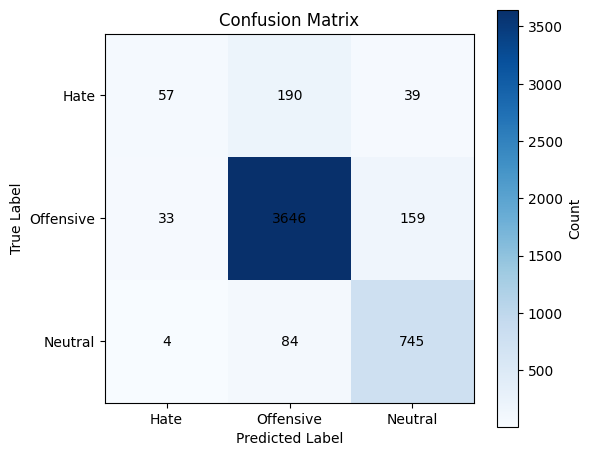

In [94]:
eval_results = evaluate_lstm_pipeline(
    model_path='lstm_model.h5',
    X_test=X_test,
    y_test=y_test
)

Hate class performance drops even more.

## No aug

In [98]:
best_params = results['best_params']
best_params

(128, 128, 0.4)

In [ ]:
X_train = pd.read_csv('Datasets/no-aug/X_train.csv').squeeze()
X_test = pd.read_csv('Datasets/no-aug/X_test.csv').squeeze()
y_train = pd.read_csv('Datasets/no-aug/Y_train.csv').squeeze()
y_test = pd.read_csv('Datasets/no-aug/Y_test.csv').squeeze()

In [100]:
MAX_VOCAB_SIZE = no_aug_vocab_len


Training final model...
Epoch 1/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 47s 147ms/step - accuracy: 0.7932 - loss: 0.6724 - val_accuracy: 0.7718 - val_loss: 0.5638
Epoch 2/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.8772 - loss: 0.3089 - val_accuracy: 0.8583 - val_loss: 0.4011
Epoch 3/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.9342 - loss: 0.1531 - val_accuracy: 0.8011 - val_loss: 0.5616
Epoch 4/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - accuracy: 0.9624 - loss: 0.0866 - val_accuracy: 0.8391 - val_loss: 0.5194
Epoch 5/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.9745 - loss: 0.0521 - val_accuracy: 0.8289 - val_loss: 0.6389
Epoch 6/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.9820 - loss: 0.0437 - val_accuracy: 0.8421 - val_loss: 0.6250
Epoch 7/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 34s 122ms/step - accuracy: 0.9864 - loss: 0.0318 - val_accuracy: 0.8365 - val_loss: 0.6938


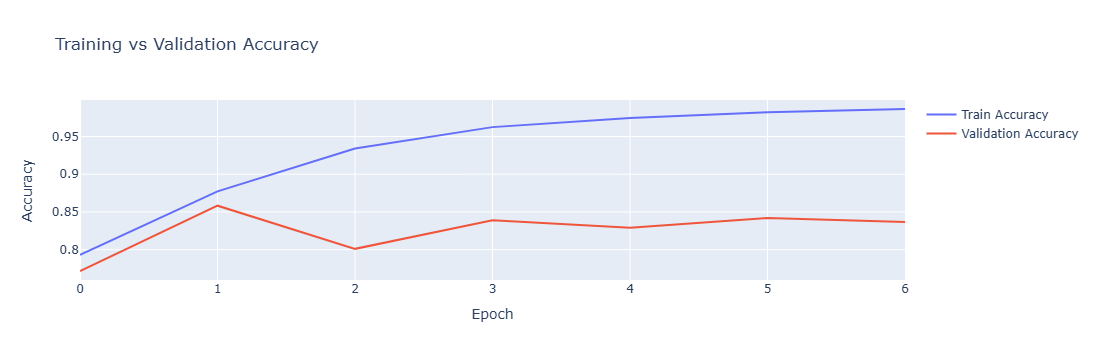

In [104]:
trainer = LSTMTrainer(base_params=best_params, model_save_path='weighted_lstm_model.keras')
results = trainer.run_pipeline(X_train, y_train, cv=False)

✓ Model loaded from: weighted_lstm_model.h5
618/618 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step

Test Accuracy: 94.72%
Test Loss: 0.1600

Classification Report:
              precision    recall  f1-score   support

        Hate     0.6036    0.9107    0.7260      1142
   Offensive     0.9907    0.9438    0.9667     15295
     Neutral     0.9350    0.9750    0.9546      3322

    accuracy                         0.9472     19759
   macro avg     0.8431    0.9432    0.8824     19759
weighted avg     0.9589    0.9472    0.9507     19759



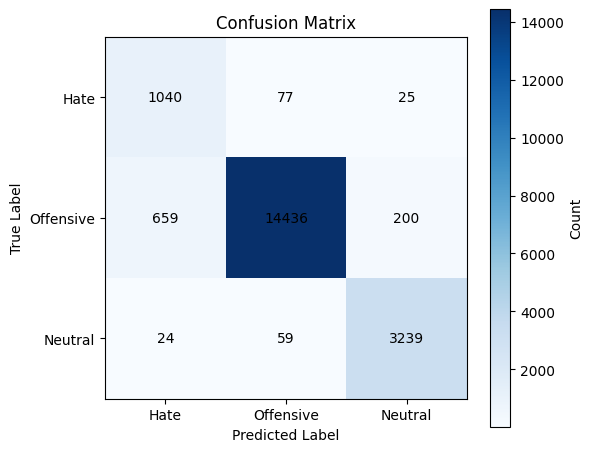

In [105]:
eval_results = evaluate_lstm_pipeline(
    model_path='weighted_lstm_model.h5',
    X_test=X_train,
    y_test=y_train
)

Using weighted matrix made the model achieve better recall for Hate class since it is getting penalized a little more for getting it wrong.

✓ Model loaded from: weighted_lstm_model.h5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Test Accuracy: 84.37%
Test Loss: 0.4328

Classification Report:
              precision    recall  f1-score   support

        Hate     0.2807    0.4790    0.3540       286
   Offensive     0.9357    0.8715    0.9025      3838
     Neutral     0.7830    0.8403    0.8107       833

    accuracy                         0.8437      4957
   macro avg     0.6665    0.7303    0.6890      4957
weighted avg     0.8722    0.8437    0.8554      4957



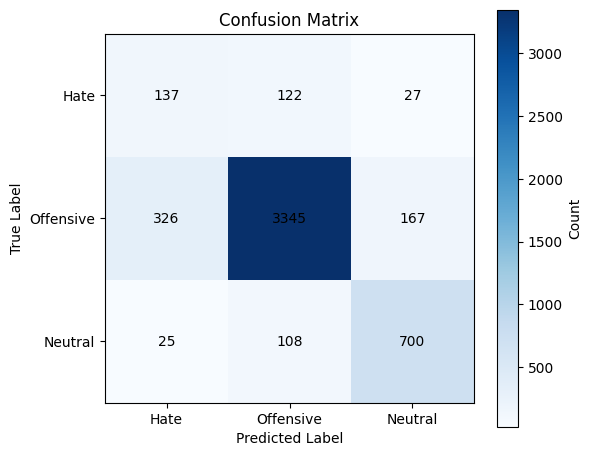

In [106]:
eval_results = evaluate_lstm_pipeline(
    model_path='weighted_lstm_model.h5',
    X_test=X_test,
    y_test=y_test
)

## Upsample (without weight class)


CV Results per configuration:
Embedding=100, LSTM=64, Dropout=0.3 → CV Accuracy: 0.8803
Embedding=100, LSTM=64, Dropout=0.4 → CV Accuracy: 0.8801
Embedding=128, LSTM=64, Dropout=0.3 → CV Accuracy: 0.8853
Embedding=128, LSTM=128, Dropout=0.4 → CV Accuracy: 0.8816

✓ Best Params: (128, 64, 0.3)
✓ Best CV Accuracy: 0.8853


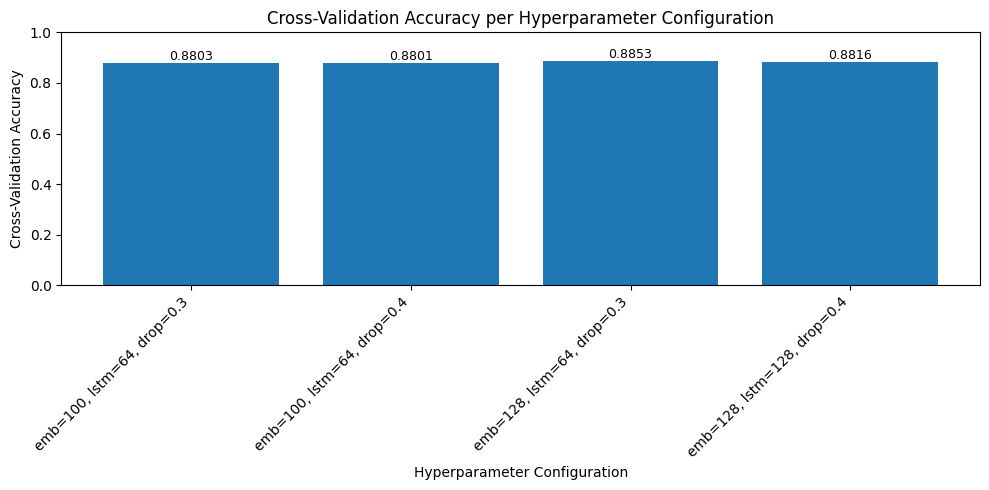


✓ Using hyperparameters: (128, 64, 0.3)

Training final model...
Epoch 1/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.8614 - loss: 0.4056 - val_accuracy: 0.9074 - val_loss: 0.2584
Epoch 2/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.9373 - loss: 0.1933 - val_accuracy: 0.9044 - val_loss: 0.2769
Epoch 3/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.9685 - loss: 0.0990 - val_accuracy: 0.8892 - val_loss: 0.3727
Epoch 4/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.9844 - loss: 0.0538 - val_accuracy: 0.8937 - val_loss: 0.3856
Epoch 5/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.9898 - loss: 0.0360 - val_accuracy: 0.8841 - val_loss: 0.4478
Epoch 6/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.9912 - loss: 0.0285 - val_accuracy: 0.8745 - val_loss: 0.5560


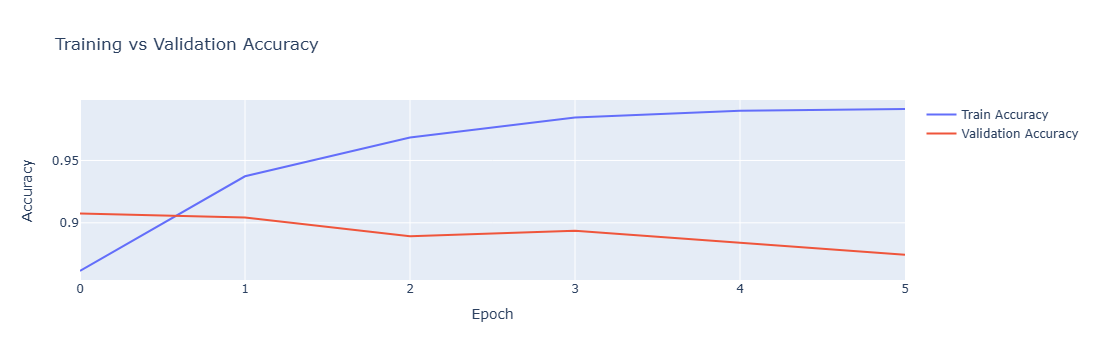

In [109]:
trainer = LSTMTrainer(model_save_path="ugmented_lstm_model.keras")
results = trainer.run_pipeline(X_train, y_train, isWeighted=False, cv=True)

✓ Model loaded from: ugmented_lstm_model.keras
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Test Accuracy: 93.46%
Test Loss: 0.2078

Classification Report:
              precision    recall  f1-score   support

        Hate     0.7880    0.2995    0.4340      1142
   Offensive     0.9486    0.9762    0.9622     15295
     Neutral     0.8909    0.9615    0.9249      3322

    accuracy                         0.9346     19759
   macro avg     0.8759    0.7457    0.7737     19759
weighted avg     0.9296    0.9346    0.9254     19759



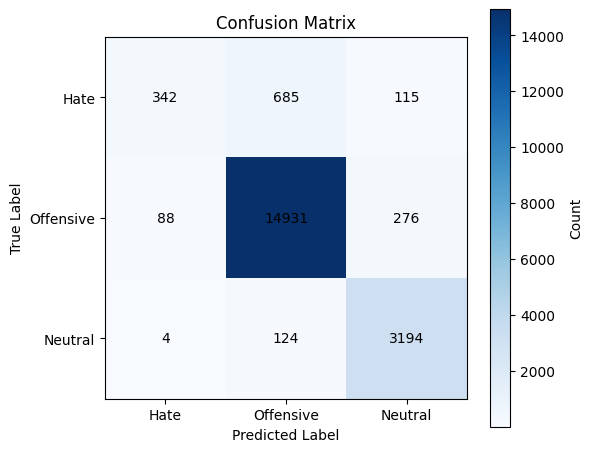

In [112]:
eval_results = evaluate_lstm_pipeline(
    model_path='ugmented_lstm_model.keras',
    X_test=X_train,
    y_test=y_train
)

✓ Model loaded from: ugmented_lstm_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Test Accuracy: 90.03%
Test Loss: 0.2800

Classification Report:
              precision    recall  f1-score   support

        Hate     0.6232    0.1503    0.2423       286
   Offensive     0.9278    0.9547    0.9411      3838
     Neutral     0.8051    0.9076    0.8533       833

    accuracy                         0.9003      4957
   macro avg     0.7854    0.6709    0.6789      4957
weighted avg     0.8896    0.9003    0.8860      4957



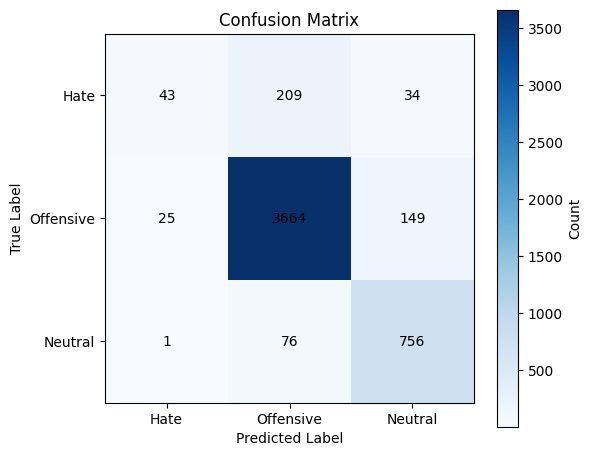

In [113]:
eval_results = evaluate_lstm_pipeline(
    model_path='ugmented_lstm_model.keras',
    X_test=X_test,
    y_test=y_test
)

Hate class performance drops significantly. This indicates that the model partially memorized training patterns related to hate, but they do not generalize well.

## Upsample

In [114]:
best_params = results['best_params']
best_params

(128, 64, 0.3)

In [ ]:
X_train = pd.read_csv('Datasets/half-aug/X_train.csv').squeeze()
X_test = pd.read_csv('Datasets/half-aug/X_test.csv').squeeze()
y_train = pd.read_csv('Datasets/half-aug/Y_train.csv').squeeze()
y_test = pd.read_csv('Datasets/half-aug/Y_test.csv').squeeze()

In [116]:
MAX_VOCAB_SIZE = up_vocab_size


Training final model...
Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8259 - loss: 0.5755 - val_accuracy: 0.8371 - val_loss: 0.4103
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9271 - loss: 0.1947 - val_accuracy: 0.8458 - val_loss: 0.4471
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9671 - loss: 0.0854 - val_accuracy: 0.8417 - val_loss: 0.5038
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9833 - loss: 0.0494 - val_accuracy: 0.8450 - val_loss: 0.5769
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9879 - loss: 0.0345 - val_accuracy: 0.8413 - val_loss: 0.6745
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9901 - loss: 0.0279 - val_accuracy: 0.8239 - val_loss: 0.8116


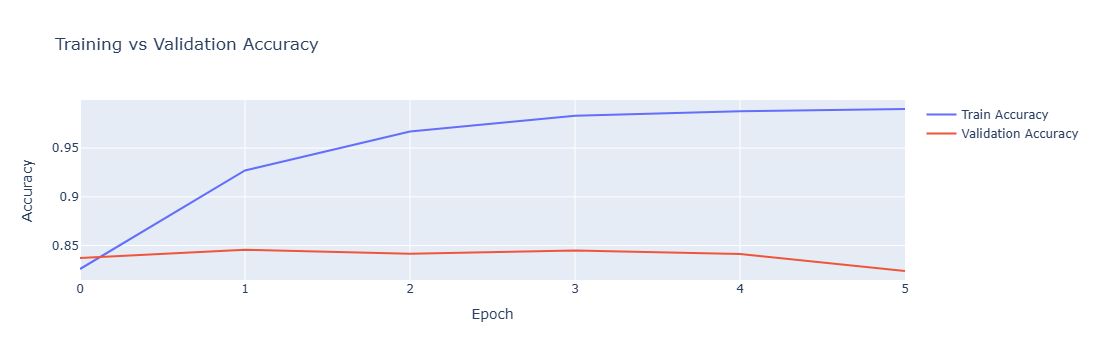

In [118]:
trainer = LSTMTrainer(base_params=best_params, model_save_path="ugmented_weighted_lstm_model.h5")
results = trainer.run_pipeline(X_train, y_train)

✓ Model loaded from: ugmented_weighted_lstm_model.h5
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Test Accuracy: 90.73%
Test Loss: 0.2599

Classification Report:
              precision    recall  f1-score   support

        Hate     0.5657    0.8885    0.6913      2278
   Offensive     0.9825    0.8833    0.9302     15295
     Neutral     0.9347    0.9692    0.9516      6617

    accuracy                         0.9073     24190
   macro avg     0.8276    0.9137    0.8577     24190
weighted avg     0.9302    0.9073    0.9136     24190



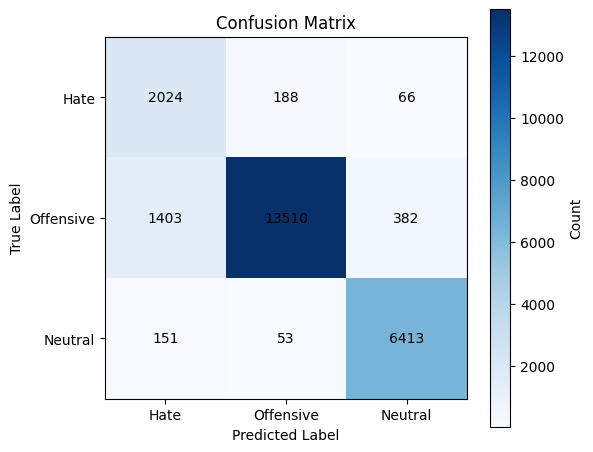

In [119]:
eval_results = evaluate_lstm_pipeline(
    model_path='ugmented_weighted_lstm_model.h5',
    X_test=X_train,
    y_test=y_train
)

After upsampling hate, its detection improved. The model now catches most hate tweets and is much less biased toward Offensive

✓ Model loaded from: ugmented_weighted_lstm_model.h5
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Test Accuracy: 84.53%
Test Loss: 0.4110

Classification Report:
              precision    recall  f1-score   support

        Hate     0.2853    0.6364    0.3939       286
   Offensive     0.9666    0.8442    0.9013      3838
     Neutral     0.7942    0.9220    0.8533       833

    accuracy                         0.8453      4957
   macro avg     0.6820    0.8008    0.7162      4957
weighted avg     0.8983    0.8453    0.8639      4957



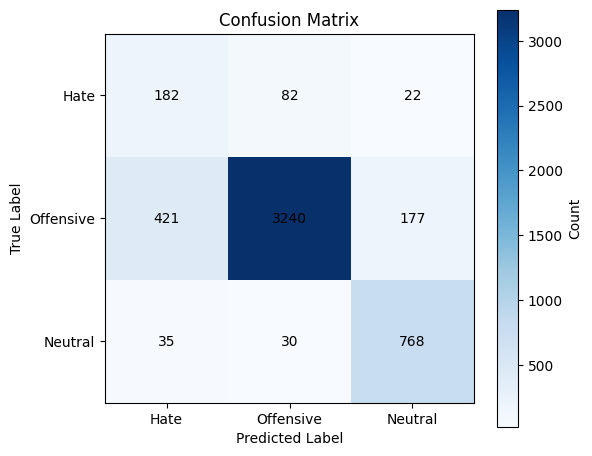

In [120]:
eval_results = evaluate_lstm_pipeline(
    model_path='ugmented_weighted_lstm_model.h5',
    X_test=X_test,
    y_test=y_test
)

Performance on test data is worse than the unbalanced model. Hate precision collapses again (0.27).
The model has overfitted to hate due to its upsampling.

## Down/Upsample (without weight class)

In [ ]:
X_train = pd.read_csv('Datasets/full-aug/X_train.csv').squeeze()
X_test = pd.read_csv('Datasets/full-aug/X_test.csv').squeeze()
y_train = pd.read_csv('Datasets/full-aug/Y_train.csv').squeeze()
y_test = pd.read_csv('Datasets/full-aug/Y_test.csv').squeeze()

In [122]:
MAX_VOCAB_SIZE = down_up_vocab_count


CV Results per configuration:
Embedding=100, LSTM=64, Dropout=0.3 → CV Accuracy: 0.8479
Embedding=100, LSTM=64, Dropout=0.4 → CV Accuracy: 0.8508
Embedding=128, LSTM=64, Dropout=0.3 → CV Accuracy: 0.8565
Embedding=128, LSTM=128, Dropout=0.4 → CV Accuracy: 0.8493

✓ Best Params: (128, 64, 0.3)
✓ Best CV Accuracy: 0.8565


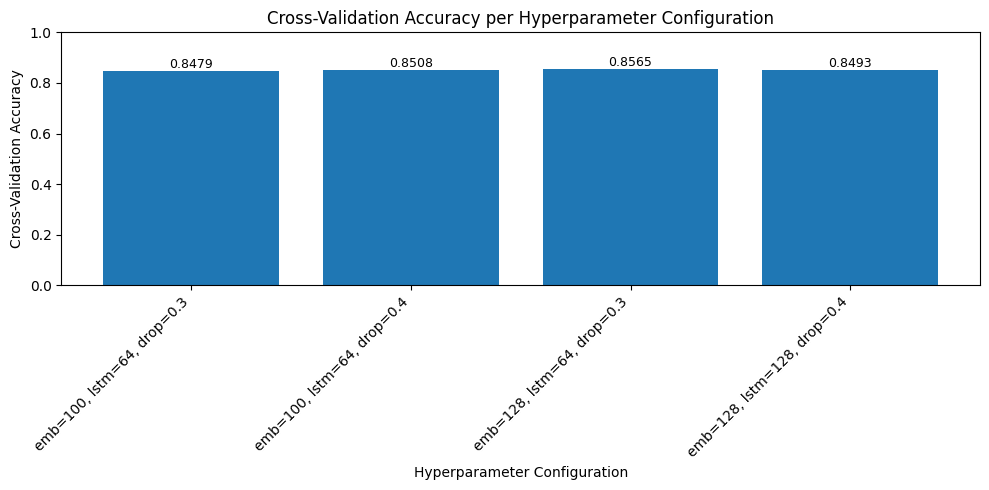


✓ Using hyperparameters: (128, 64, 0.3)

Training final model...
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.7353 - loss: 0.6511 - val_accuracy: 0.8671 - val_loss: 0.3700
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9178 - loss: 0.2397 - val_accuracy: 0.8931 - val_loss: 0.3115
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9717 - loss: 0.0928 - val_accuracy: 0.8911 - val_loss: 0.3333
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9859 - loss: 0.0501 - val_accuracy: 0.8776 - val_loss: 0.4065
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9924 - loss: 0.0279 - val_accuracy: 0.8786 - val_loss: 0.4500
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9931 - loss: 0.0218 - val_accuracy: 0.8805 - val_loss: 0.4856
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9957 - loss: 0.0145 - val_accuracy: 0.8622 - val_loss: 0.5468


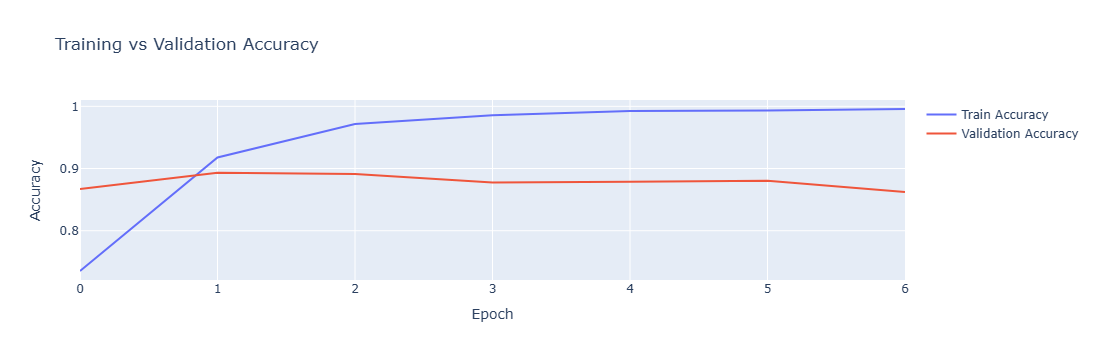

In [123]:
trainer = LSTMTrainer(model_save_path="downsampled_ugmented_lstm_model.h5")
results = trainer.run_pipeline(X_train, y_train, isWeighted=False, cv=True)

✓ Model loaded from: downsampled_ugmented_lstm_model.h5
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Test Accuracy: 96.20%
Test Loss: 0.1242

Classification Report:
              precision    recall  f1-score   support

        Hate     0.9594    0.9114    0.9348      2280
   Offensive     0.9530    0.9718    0.9623      4780
     Neutral     0.9769    0.9828    0.9799      3320

    accuracy                         0.9620     10380
   macro avg     0.9631    0.9553    0.9590     10380
weighted avg     0.9621    0.9620    0.9619     10380



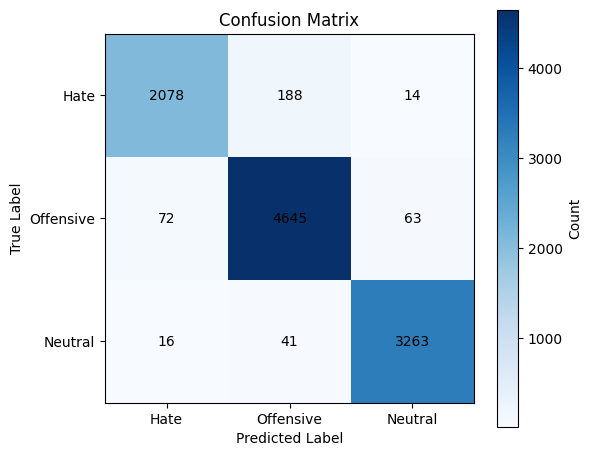

In [124]:
eval_results = evaluate_lstm_pipeline(
    model_path='downsampled_ugmented_lstm_model.h5',
    X_test=X_train,
    y_test=y_train
)

An attempt to do both up and down sampling improved the results on the training data

✓ Model loaded from: downsampled_ugmented_lstm_model.h5
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Test Accuracy: 85.38%
Test Loss: 0.4506

Classification Report:
              precision    recall  f1-score   support

        Hate     0.6202    0.4510    0.5223       286
   Offensive     0.8837    0.8925    0.8881      1200
     Neutral     0.8676    0.9364    0.9007       833

    accuracy                         0.8538      2319
   macro avg     0.7905    0.7600    0.7703      2319
weighted avg     0.8454    0.8538    0.8475      2319



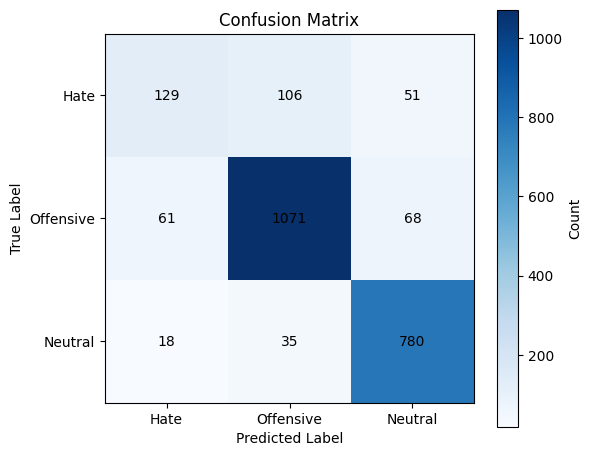

In [125]:
eval_results = evaluate_lstm_pipeline(
    model_path='downsampled_ugmented_lstm_model.h5',
    X_test=X_test,
    y_test=y_test
)

But it didn't work well on the testing data

## Down/Upsample

In [126]:
best_params = results['best_params']
best_params

(128, 64, 0.3)

In [ ]:
X_train = pd.read_csv('Datasets/full-aug/X_train.csv').squeeze()
X_test = pd.read_csv('Datasets/full-aug/X_test.csv').squeeze()
y_train = pd.read_csv('Datasets/full-aug/Y_train.csv').squeeze()
y_test = pd.read_csv('Datasets/full-aug/Y_test.csv').squeeze()

In [128]:
MAX_VOCAB_SIZE = down_up_vocab_count


Training final model...
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7802 - loss: 0.6642 - val_accuracy: 0.8487 - val_loss: 0.4048
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9228 - loss: 0.2304 - val_accuracy: 0.8921 - val_loss: 0.2911
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9717 - loss: 0.0892 - val_accuracy: 0.8728 - val_loss: 0.3717
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9866 - loss: 0.0480 - val_accuracy: 0.8516 - val_loss: 0.5089
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9910 - loss: 0.0314 - val_accuracy: 0.8690 - val_loss: 0.4512
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9919 - loss: 0.0250 - val_accuracy: 0.8536 - val_loss: 0.5432
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9937 - loss: 0.0229 - val_accuracy: 0.8690 - val_loss: 0.4931


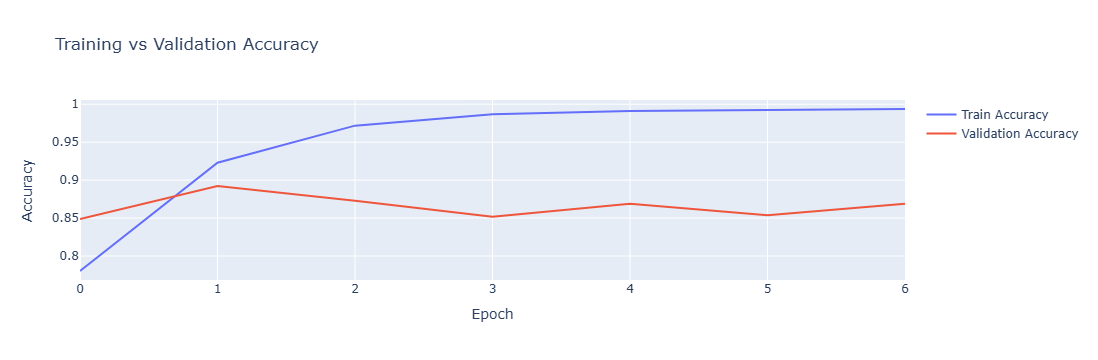

In [129]:
trainer = LSTMTrainer(base_params=best_params, model_save_path="weighted_downsampled_ugmented_lstm_model.keras")
results = trainer.run_pipeline(X_train, y_train)

✓ Model loaded from: weighted_downsampled_ugmented_lstm_model.keras
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Test Accuracy: 96.40%
Test Loss: 0.1185

Classification Report:
              precision    recall  f1-score   support

        Hate     0.9437    0.9342    0.9389      2280
   Offensive     0.9633    0.9663    0.9648      4780
     Neutral     0.9787    0.9810    0.9798      3320

    accuracy                         0.9640     10380
   macro avg     0.9619    0.9605    0.9612     10380
weighted avg     0.9639    0.9640    0.9639     10380



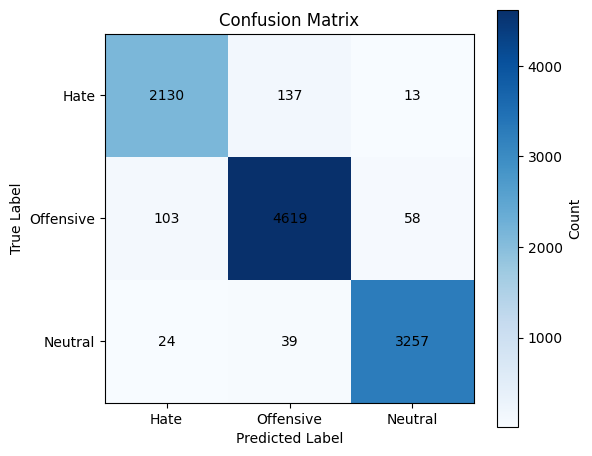

In [131]:
eval_results = evaluate_lstm_pipeline(
    model_path='weighted_downsampled_ugmented_lstm_model.keras',
    X_test=X_train,
    y_test=y_train
)

✓ Model loaded from: weighted_downsampled_ugmented_lstm_model.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Test Accuracy: 85.60%
Test Loss: 0.4446

Classification Report:
              precision    recall  f1-score   support

        Hate     0.5794    0.5105    0.5428       286
   Offensive     0.8888    0.8925    0.8906      1200
     Neutral     0.8910    0.9220    0.9062       833

    accuracy                         0.8560      2319
   macro avg     0.7864    0.7750    0.7799      2319
weighted avg     0.8514    0.8560    0.8533      2319



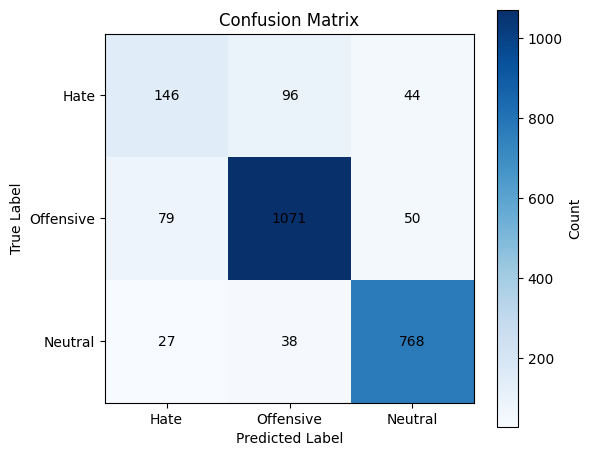

In [132]:
eval_results = evaluate_lstm_pipeline(
    model_path='weighted_downsampled_ugmented_lstm_model.keras',
    X_test=X_test,
    y_test=y_test
)

Doing down-up sampling without class weights gave better results since resampling with class weights over-penalizes the minority class

# Conclusion

Due to severe class imbalance, macro-F1 was used as the primary evaluation metric.
Using class weights alone improved training performance but didn't give good performance in testing.
In contrast, data-level balancing was more effective, with combined upsampling and downsampling achieving the highest test macro-F1 and best minority-class detection.
Combining class weights with augmentation provided no additional benefit and increased overfitting.
Therefore, data-level balancing without class weights was selected as the final and most reliable approach.